# Agentic RAG (Self-RAG)

## Setting
 - Auto Reload
 - path for utils

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
module_path = "../../.."
sys.path.append(os.path.abspath(module_path))

## 1. Create Bedrock client

In [3]:
from pprint import pprint
from termcolor import colored
from utils import bedrock
from utils.bedrock import bedrock_info

### ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----
- os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
- os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
- os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
- os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."

In [4]:
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models(verbose=False))

Create new client
  Using region: None
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-west-2.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-5-Sonnet': 'anthropic.claude-3-5-sonnet-20240620-v1:0',
 'Claude-V3-5-V-2-Sonnet': 'anthropic.claude-3-5-sonnet-20241022-v2:0',
 'Claude-V3-5-V-2-Sonnet-CRI': 'us.anthropic.claude-3-5-sonnet-20241022-v2:0',
 'Claude-V3-7-Sonnet-CRI': 'us.anthropic.claude-3-7-sonnet-20250219-v1:0',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Opus': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Comma

## 2. LLM, Embedding model 정의

In [5]:
from utils.bedrock import bedrock_model
from langchain_aws import BedrockEmbeddings
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [6]:
llm = bedrock_model(
    #model_id=bedrock_info.get_model_id(model_name="Claude-V3-7-Sonnet-CRI"),
    model_id=bedrock_info.get_model_id(model_name="Nova-Pro-CRI"),
    
    bedrock_client=boto3_bedrock,
    stream=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    inference_config={
        'maxTokens': 1024,
        'stopSequences': ["\n\nHuman"],
        'temperature': 0.01,
    }
)

In [7]:
emb = BedrockEmbeddings(client=boto3_bedrock, model_id = "amazon.titan-embed-text-v2:0")
dimension = 1024

## 3. Vector store

In [8]:
import boto3
from utils.ssm import parameter_store

In [9]:
region=boto3.Session().region_name
pm = parameter_store(region)

### 3.1 Get index name

In [10]:
opensearch_domain_endpoint = pm.get_params(key="opensearch_domain_endpoint", enc=False)
opensearch_user_id = pm.get_params(key="opensearch_user_id", enc=False)
opensearch_user_password = pm.get_params(key="opensearch_user_password", enc=True)

http_auth = (opensearch_user_id, opensearch_user_password) # Master username, Master password
index_name = opensearch_user_password = pm.get_params(key="opensearch_index_name", enc=True)
print (f'index_name: {index_name}')

index_name: default-index


### 3.2 Get opensearch client

In [11]:
from utils.opensearch import opensearch_utils

In [12]:
os_client = opensearch_utils.create_aws_opensearch_client(region, opensearch_domain_endpoint, http_auth)

## 4. Agents

In [13]:
import time
import json
import pprint
from termcolor import colored

from textwrap import dedent
from utils.bedrock import bedrock_utils
from typing import TypedDict, List
from src.genai_analysis import llm_call
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables import RunnableConfig

from utils.common_utils import retry
from utils.agentic_rag import OpenSearchHybridSearchRetriever, show_context_used
from botocore.exceptions import ClientError, ConnectionError, ConnectTimeoutError, ReadTimeoutError

In [14]:
class TimeMeasurement:
    def __init__(self):
        self.start_time = None
        self.measurements = {}

    def start(self):
        self.start_time = time.time()

    def measure(self, section_name):
        if self.start_time is None:
            raise ValueError("start() 메서드를 먼저 호출해야 합니다.")
        
        end_time = time.time()
        elapsed_time = end_time - self.start_time
        self.measurements[section_name] = elapsed_time
        self.start_time = end_time  # 다음 구간 측정을 위해 시작 시간 재설정

    def reset(self, ):
        self.measurements = {}

    def print_measurements(self):
        for section, elapsed_time in self.measurements.items():
            #print(f"{section}: {elapsed_time:.5f} 초")
            print(colored (f"\nelapsed time: {section}: {elapsed_time:.5f} 초", "red"))

### 4.1 Agent state 

In [15]:
class GraphState(TypedDict):
    query: str
    documents: List[str]
    generation: str
    query_revision_count: int
    enhanced_answer: str

In [16]:
class self_rag():

    def __init__(self, **kwargs):

        self.timer = TimeMeasurement()
        
        self.llm, self.emb = kwargs["llm"], kwargs["emb"]
        os_client, index_name = kwargs["os_client"], kwargs["index_name"]
        self.query_regeneration_limit = kwargs["query_regeneration_limit"]
        self.state = GraphState

        self.retriever = self.get_retriever(os_client=os_client, index_name=index_name)        

        self._graph_definition()
        self.messages = []
        self.contexts, self.enhanced_contexts = [], []
        self.generation, self.enhanced_generation = "", ""

    def _get_string_from_message(self, message):
        return message["content"][0]["text"]

    def _get_message_from_string(self, role, string, imgs=None):
        
        message = {
            "role": role,
            "content": []
        }
        
        if imgs is not None:
            for img in imgs:
                img_message = {
                    "image": {
                        "format": 'png',
                        "source": {"bytes": img}
                    }
                }
                message["content"].append(img_message)
        
        message["content"].append({"text": dedent(string)})

        return message
            
    def get_messages(self, ):
        return self.messages

    def get_retriever(self, **kwargs):

        os_client, index_name = kwargs["os_client"], kwargs["index_name"]
        
        opensearch_hybrid_retriever = OpenSearchHybridSearchRetriever(
            os_client=os_client,
            index_name=index_name,
            llm_text=self.llm, # llm for query augmentation in both rag_fusion and HyDE
            llm_emb=self.emb, # Used in semantic search based on opensearch 
        
            # hybird-search debugger
            hybrid_search_debugger="None", #[semantic, lexical, None]
            
            # option for lexical
            minimum_should_match=0,
            filter=[],
        
            # option for search
            fusion_algorithm="RRF", # ["RRF", "simple_weighted"], rank fusion 방식 정의
            ensemble_weights=[.51, .49], # [for semantic, for lexical], Semantic, Lexical search 결과에 대한 최종 반영 비율 정의
            reranker=True, # enable reranker with reranker model
            reranker_endpoint_name="cohere-reranker-3-5", # endpoint name for reranking model
            parent_document=False, # enable parent document
                        
            # option for complex documents consisting of text, table and image
            complex_doc=False,
            
            # option for async search
            async_mode=True,
        
            # option for output
            k=3, # 최종 Document 수 정의
            verbose=False,
        )

        return opensearch_hybrid_retriever

    #DO NOT include any text or json symbol (```json```)outside the JSON format in the response
    @retry(total_try_cnt=5, sleep_in_sec=10, retryable_exceptions=(ClientError,))
    def retrieval_grader(self, **kwargs):

        query, document = kwargs["query"], kwargs["document"]
        messages = []
        
        self.llm.stream = False
        llm_caller = llm_call(llm=self.llm, verbose=False)
        
        system_prompts = dedent(
            '''
            You are a grader assessing relevance of a retrieved document to a user question.
            It does not need to be a stringent test. The goal is to filter out erroneous retrievals.
            If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant.
            
            Output in the following JSON format:
            You must ONLY output the JSON object, nothing else.
            NO descriptions of what you're doing before or after JSON.
            <output_format>
            {
                "binary_score": "grade results (yes/no)"
            }
            </output_format>
            '''
        )
  
        system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)
        user_prompts = dedent(
            '''
            Retrieved document: <document>{document}</document>
            User question: <question>{query}</question>
            '''
        )        
        context = {"document": document, "query": query}
        user_prompts = user_prompts.format(**context)
                   
        message = self._get_message_from_string(role="user", string=user_prompts)
        messages.append(message)
        resp, ai_message = llm_caller.invoke(messages=messages, system_prompts=system_prompts)
        
        # Parse JSON from the response
        try:
            results = json.loads(resp["text"])
            return results
            
        except json.JSONDecodeError:
            # Fallback parsing if model doesn't return proper JSON
            if "yes" in resp["text"].lower(): return {"binary_score": "yes"}
            else: return {"binary_score": "no"}

    @retry(total_try_cnt=5, sleep_in_sec=10, retryable_exceptions=(ClientError,))
    def question_rewriter(self, **kwargs):

        query = kwargs["query"]
        messages = []
        
        self.llm.stream = False
        llm_caller = llm_call(llm=self.llm, verbose=False)

        system_prompts = dedent(
            '''
            You are a question re-writer that converts an input question to a better version that is optimized for vectorstore retrieval.
            Look at the input and try to reason about the underlying semantic intent/meaning.

            Output in the following JSON format:
            You must ONLY output the JSON object, nothing else.
            NO descriptions of what you're doing before or after JSON.
            <output_format>
            {
                "re-written": "re-written question"
            }
            </output_format>
            '''
        )
  
        system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)
        user_prompts = dedent(
            '''
            Initial question: <question>{query}</question>
            Formulate an improved question.
            '''
        )
        
        context = {"query": query}
        user_prompts = user_prompts.format(**context)
                   
        message = self._get_message_from_string(role="user", string=user_prompts)
        messages.append(message)
        resp, ai_message = llm_caller.invoke(messages=messages, system_prompts=system_prompts)

        # Parse JSON from the response
        try:
            results = json.loads(resp["text"])
            return results
            
        except json.JSONDecodeError:
            # Fallback parsing if model doesn't return proper JSON
            return {"re-written": resp["text"].lower()}

    @retry(total_try_cnt=5, sleep_in_sec=10, retryable_exceptions=(ClientError,))
    def hallucination_grader(self, **kwargs):

        documents, generation = kwargs["documents"], kwargs["generation"]
        messages = []
        
        self.llm.stream = False
        llm_caller = llm_call(llm=self.llm, verbose=False)
        
        system_prompts = dedent(
            '''
            You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts.
            Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts.
            
            Output in the following JSON format:
            You must ONLY output the JSON object, nothing else.
            NO descriptions of what you're doing before or after JSON.
            <output_format>
            {
                "binary_score": "grade results (yes/no)",
            }
            </output_format>
            '''
         )
        
        system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)
        user_prompts = dedent(
            '''
            Set of facts: <documents>{documents}</documents>
            LLM generation: <generation>{generation}</generation>
            '''
        )
        reformat_documents = "\n\n".join(doc.page_content for doc in documents)
        context = {"documents": reformat_documents, "generation": generation}
        user_prompts = user_prompts.format(**context)
                   
        message = self._get_message_from_string(role="user", string=user_prompts)
        messages.append(message)
        resp, ai_message = llm_caller.invoke(messages=messages, system_prompts=system_prompts)
        
        # Parse JSON from the response
        try:
            results = json.loads(resp["text"])
            return results
            
        except json.JSONDecodeError:
            # Fallback parsing if model doesn't return proper JSON
            if "yes" in resp["text"].lower(): return {"binary_score": "yes"}
            else: return {"binary_score": "no", "feedback": "none"}

    @retry(total_try_cnt=5, sleep_in_sec=10, retryable_exceptions=(ClientError,))
    def answer_grader(self, **kwargs):

        query, generation = kwargs["query"], kwargs["generation"]
        messages = []
        
        self.llm.stream = False
        llm_caller = llm_call(llm=self.llm, verbose=False)

        #If your score is 'no', also explain which parts of the generation are not enough and why.
        #"feedback": "explanation of what information in the generation is not enough for question (if binary_score is no)"
        system_prompts = dedent(
            '''
            You are a grader assessing whether an answer addresses / resolves a question.
            Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question.
            
            
            Output in the following JSON format:
            You must ONLY output the JSON object, nothing else.
            NO descriptions of what you're doing before or after JSON.
            <output_format>
            {
                "binary_score": "grade results (yes/no)"
            }
            </output_format>
            '''
        )
  
        system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)
        user_prompts = dedent(
            '''
            User question: <question>{query}</question>
            LLM generation: <generation>{generation}</generation>
            '''
        )
        context = {"query": query, "generation": generation}
        user_prompts = user_prompts.format(**context)
                   
        message = self._get_message_from_string(role="user", string=user_prompts)
        messages.append(message)
        resp, ai_message = llm_caller.invoke(messages=messages, system_prompts=system_prompts)

        # Parse JSON from the response
        try:
            results = json.loads(resp["text"])
            return results
            
        except json.JSONDecodeError:
            # Fallback parsing if model doesn't return proper JSON
            if "yes" in resp["text"].lower(): return {"binary_score": "yes"}
            else: return {"binary_score": "no"}
                
    @retry(total_try_cnt=5, sleep_in_sec=10, retryable_exceptions=(ClientError,))
    def answer_enhancer(self, **kwargs):

        query, generation = kwargs["query"], kwargs["generation"]
        messages = []
        
        self.llm.stream = False
        llm_caller = llm_call(llm=self.llm, verbose=False)

        #If your score is 'no', also explain which parts of the generation are not enough and why.
        #"feedback": "explanation of what information in the generation is not enough for question (if binary_score is no)"
        system_prompts = dedent(
            '''
            You are a tool that analyzes questions and their answers to suggest additional search queries for improved answer.
            Propose up to 5 search queries.

            Guidelines:
            - Create specific, searchable queries
            - Focus on insufficient information or topics that need deeper exploration
            - Exclude topics already well-covered in the current answer
            - Stay within the intent of the original question

            Output in the following JSON format:
            You must ONLY output the JSON object, nothing else.
            NO descriptions of what you're doing before or after JSON.
            <output_format>
            {
                "suggested_query": "['query1', 'query2']"
            }
            </output_format>
            '''
        )
  
        system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)
        user_prompts = dedent(
            '''
            User question: <question>{query}</question>
            Answers: <answers>{generation}</answers>
            '''
        )
        context = {"query": query, "generation": generation}
        user_prompts = user_prompts.format(**context)
                   
        message = self._get_message_from_string(role="user", string=user_prompts)
        self.messages.append(message)
        resp, ai_message = llm_caller.invoke(messages=self.messages, system_prompts=system_prompts)

        # Parse JSON from the response
        results = json.loads(resp["text"])
        return results
            
    @retry(total_try_cnt=5, sleep_in_sec=10, retryable_exceptions=(ClientError,))
    def rag_chain(self, **kwargs):

        query, documents = kwargs["query"], kwargs["documents"]
        messages = []
        
        self.llm.stream = True
        llm_caller = llm_call(llm=self.llm, verbose=False)

        system_prompts = dedent(
            '''
            You are an assistant for question-answering tasks.
            Use the following pieces of retrieved documents to answer the question.
            Skip the preamble and go straight into the answer.
            If you don't know the answer, just say that you don't know.
            '''
        )
  
        system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)
        user_prompts = dedent(
            '''
            Documents: <documents>{documents}</documents>
            User question: <question>{query}</question>
            '''
        )        

        reformat_documents = "\n\n".join(doc.page_content for doc in documents)
        context = {"documents": reformat_documents, "query": query}
        user_prompts = user_prompts.format(**context)
                   
        message = self._get_message_from_string(role="user", string=user_prompts)
        self.messages.append(message)
        resp, ai_message = llm_caller.invoke(messages=self.messages, system_prompts=system_prompts)
        self.messages.append(ai_message)

        return resp["text"]
        
    @retry(total_try_cnt=5, sleep_in_sec=10, retryable_exceptions=(ClientError,))
    def enhanced_answer_chain(self, **kwargs):

        query, generation, suggested_query, enhanced_documents = kwargs["query"], kwargs["generation"], kwargs["suggested_query"], kwargs["enhanced_documents"] 
        messages = []
        
        self.llm.stream = True
        llm_caller = llm_call(llm=self.llm, verbose=False)

        system_prompts = dedent(
            '''
            You are an advanced assistant that improves answers based on additional context and follow-up questions.

            Input:
            - Original question
            - Initial generated answer
            - Follow-up questions that were created to enhance the original answer
            - Enhanced documents related to these follow-up questions
            
            Task:
            Create an improved, comprehensive answer to the original question by incorporating the initial answer and the new information from the enhanced documents.
            
            Guidelines:
            - Skip the preamble and go straight into the answer
            - Begin with the original answer as your foundation
            - Seamlessly integrate relevant information from the enhanced documents
            - Maintain a coherent structure and natural flow throughout
            - Add depth and nuance where the initial answer was incomplete
            - Correct any inaccuracies found in the initial answer
            - Ensure all claims are supported by the available information
            - Maintain an informative and helpful tone
            - If contradictory information exists between sources, acknowledge it and explain different perspectives
            - If the enhanced documents don't provide additional useful information, state that the original answer remains the most accurate response
            
            Remember: Your goal is to create the most complete, accurate, and helpful response to the original question using all available information.
            '''
        )
  
        system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)
        user_prompts = dedent(
            '''
            User question: <question>{query}</question>
            Answers: <answers>{generation}</answers>
            Enhanced documents: <enhanced_documents>{enhanced_documents}</enhanced_documents>
            Follow-up questions: <followup_questions>{followup_questions}</followup_questions>
            '''
        )        

        context = {"query": query, "generation": generation, "followup_questions": suggested_query, "enhanced_documents": enhanced_documents}
        user_prompts = user_prompts.format(**context)
                   
        message = self._get_message_from_string(role="user", string=user_prompts)
        messages.append(message)
        resp, ai_message = llm_caller.invoke(messages=messages, system_prompts=system_prompts)
        self.messages.append(ai_message)

        return resp["text"]
        
    def _graph_definition(self, **kwargs):

        def retrieve(state):
            """
            Retrieve documents
        
            Args:
                state (dict): The current graph state
        
            Returns:
                state (dict): New key added to state, documents, that contains retrieved documents
            """
            print("---RETRIEVE---")
            query = state["query"]
        
            # Retrieval
            if self.retriever.complex_doc: documents, tables, images = self.retriever.invoke(query)
            else: documents = self.retriever.invoke(query)
            
            return {"documents": documents, "query": query}

        def grade_documents(state):

            """
            Determines whether the retrieved documents are relevant to the question.
        
            Args:
                state (dict): The current graph state
        
            Returns:
                state (dict): Updates documents key with only filtered relevant documents
            """
        
            print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
            query, documents = state["query"], state["documents"]
        
            # Score each doc
            filtered_docs = []
            for idx, d in enumerate(documents):
                grade_result = self.retrieval_grader(query=query, document=d.page_content)
                
                if grade_result["binary_score"] == "yes":
                    print(f"  ---Document {idx}: GRADE: DOCUMENT RELEVANT---")
                    filtered_docs.append(d)
                else:
                    print(f"  ---Document {idx}: GRADE: DOCUMENT NOT RELEVANT---")
                    continue
                    
            self.contexts = filtered_docs
            return {"documents": filtered_docs, "query": query}

        def decide_to_generate(state):
            """
            Determines whether to generate an answer, or re-generate a question.
        
            Args:
                state (dict): The current graph state
        
            Returns:
                str: Binary decision for next node to call
            """
        
            print("---ASSESS GRADED DOCUMENTS---")
            filtered_documents = state["documents"]
            query_revision_count = state.get("query_revision_count", 0)

            if (not filtered_documents) and query_revision_count < self.query_regeneration_limit:
            #if len(filtered_documents) < 7 and query_revision_count < self.query_regeneration_limit:
                # All documents have been filtered check_relevance
                # We will re-generate a new query
                print("  ---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---")
                return "transform_query"
            else:
                # We have relevant documents, so generate answer
                print("  ---DECISION: GENERATE---")
                return "generate"

        def transform_query(state):
            """
            Transform the query to produce a better question.
        
            Args:
                state (dict): The current graph state
        
            Returns:
                state (dict): Updates question key with a re-phrased question
            """
        
            print("---TRANSFORM QUERY---")
            query, documents = state["query"], state["documents"]
            query_revision_count = state.get("query_revision_count", 0)
            
            # Re-write question
            results = self.question_rewriter(query=query)
            better_question = results["re-written"]
            query_revision_count += 1
            
            return {"documents": documents, "query": better_question, "query_revision_count": query_revision_count}
        
        def generate(state):
            """
            Generate answer
        
            Args:
                state (dict): The current graph state
        
            Returns:
                state (dict): New key added to state, generation, that contains LLM generation
            """
            print("---GENERATE---")
            query, documents = state["query"], state["documents"]
            feedback = state.get("feedback", None)
            
            # RbAG generation
            generation = self.rag_chain(query=query, documents=documents)
            self.generation = generation
            
            query_revision_count = state.get("query_revision_count", 0)
            query_revision_count = 0
            
            return {"documents": documents, "query": query, "generation": generation, "query_revision_count": query_revision_count}

        def grade_generation_v_documents_and_question(state):
            """
            Determines whether the generation is grounded in the document and answers question.
        
            Args:
                state (dict): The current graph state
        
            Returns:
                str: Decision for next node to call
            """
        
            print("\n---CHECK HALLUCINATIONS: 컨택스트 기반 답변인지 확인---")
            query, documents, generation = state["query"], state["documents"], state["generation"]
            hallucination_results = self.hallucination_grader(documents=documents, generation=generation)

            # Check hallucination
            if hallucination_results["binary_score"] == "yes":
                print("  ---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
                # Check question-answering
                print("---GRADE GENERATION vs QUESTION---")
                answer_grade_results = self.answer_grader(query=query, generation=generation)
                if answer_grade_results["binary_score"] == "yes":
                    print("  ---DECISION: GENERATION ADDRESSES QUESTION---")
                    return "useful"
                else:
                    print("  ---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
                    return "not useful"
            else:
                pprint("  ---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
                return "not supported"    
                
        def enhance_answer(state):
            """
            Enhance answer quality 
        
            Args:
                state (dict): The current graph state
        
            Returns:
                state (dict): New key added to state, generation, that contains LLM generation
            """
            print("---ENHANCE ANSWER---")
            query, documents, generation = state["query"], state["documents"], state["generation"]
            
            answer_enhancer_results = self.answer_enhancer(query=query, generation=generation)
            suggested_query = answer_enhancer_results["suggested_query"]
 
            # Retrieval
            enhanced_documents = []
            for suggested_query in suggested_query:
                
                if self.retriever.complex_doc: documents, tables, images = self.retriever.invoke(query)    
                else: documents = self.retriever.invoke(query)
                    
                enhanced_documents.extend(documents)

            enhanced_answer = self.enhanced_answer_chain(
                query=query, generation=generation, suggested_query=suggested_query, enhanced_documents=enhanced_documents
            )
            self.enhanced_contexts = enhanced_documents
            self.enhanced_generation = enhanced_answer

            return {"enhanced_answer": enhanced_answer}

            
        # langgraph.graph에서 StateGraph와 END를 가져옵니다.
        workflow = StateGraph(self.state)

        # Todo 를 작성합니다.
        workflow.add_node("retrieve", retrieve)
        workflow.add_node("grade_documents", grade_documents)
        workflow.add_node("transform_query", transform_query)
        workflow.add_node("generate", generate)
        workflow.add_node("enhance_answer", enhance_answer)
        enhance_answer
        
        workflow.add_edge(START, "retrieve")
        workflow.add_edge("retrieve", "grade_documents")
        workflow.add_conditional_edges(
            "grade_documents",
            decide_to_generate,
            {
                "transform_query": "transform_query",
                "generate": "generate",
            },
        )
        workflow.add_edge("transform_query", "retrieve")
        workflow.add_conditional_edges(
            "generate",
            grade_generation_v_documents_and_question,
            {
                "not supported": "generate",
                "useful": "enhance_answer",
                "not useful": "transform_query",
            },
        )
        
        workflow.add_edge("enhance_answer", END)

        # 기록을 위한 메모리 저장소를 설정합니다.
        memory = MemorySaver()

        # 그래프를 컴파일합니다.
        self.app = workflow.compile(checkpointer=memory)        
        self.config = RunnableConfig(recursion_limit=100, configurable={"thread_id": "self_rag"})

    def invoke(self, **kwargs):
        
        inputs = self.state(query=kwargs["query"])
        
        # app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
        for output in self.app.stream(inputs, self.config):
            # 출력된 결과에서 키와 값을 순회합니다.
            for key, value in output.items():
                # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
                print(f"\nOutput from node '{key}':")
                #print("---")
                
                #print (self.messages)
                # 출력 값을 예쁘게 출력합니다.
                #pprint.pprint(value, indent=2, width=80, depth=None)
                
            # 각 출력 사이에 구분선을 추가합니다.
            print("\n-------------------------------------------------------\n")

        print("---Answer---")
        print(colored(self.generation, "green"))
        print("---Filtered Contexts---")
        show_context_used(self.contexts)
        print("---Enhanced Answer---")
        print (colored(self.enhanced_generation, "green"))
        print("---Enhanced Contexts---")
        show_context_used(self.enhanced_contexts)
            
    def show_graph(self, ):
        
        from IPython.display import Image, display

        try:
            # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. 
            display(Image(self.app.get_graph(xray=True).draw_mermaid_png()))  
        except:
            pass


In [17]:
rag_client = self_rag(
    llm=llm,
    emb=emb,
    os_client=os_client,
    index_name=index_name,
    query_regeneration_limit=2
)

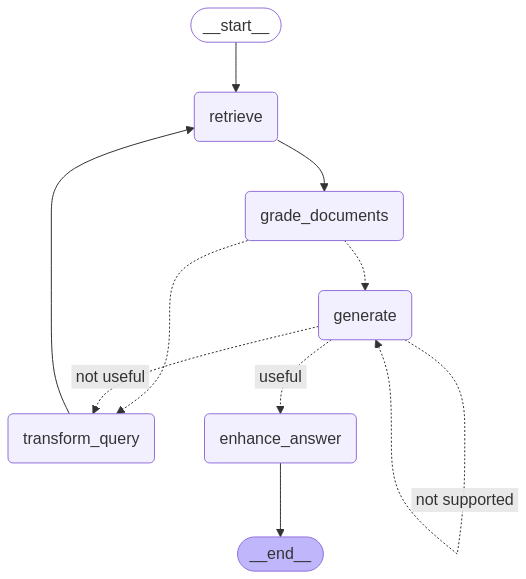

In [18]:
rag_client.show_graph()

In [19]:
rag_client.invoke(
    query="vidio max size?"
)

---RETRIEVE---


/home/ec2-user/anaconda3/envs/agentic_rag/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
INFO:retry-bedrock-invocation:trying retrieval_grader() [1/5]



Output from node 'retrieve':

-------------------------------------------------------

---CHECK DOCUMENT RELEVANCE TO QUESTION---


INFO:retry-bedrock-invocation:in retry(), retrieval_grader() returned '{'binary_score': 'yes'}'
INFO:retry-bedrock-invocation:trying retrieval_grader() [1/5]


  ---Document 0: GRADE: DOCUMENT RELEVANT---


INFO:retry-bedrock-invocation:in retry(), retrieval_grader() returned '{'binary_score': 'no'}'
INFO:retry-bedrock-invocation:trying retrieval_grader() [1/5]


  ---Document 1: GRADE: DOCUMENT NOT RELEVANT---


INFO:retry-bedrock-invocation:in retry(), retrieval_grader() returned '{'binary_score': 'no'}'
INFO:retry-bedrock-invocation:trying rag_chain() [1/5]


  ---Document 2: GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
  ---DECISION: GENERATE---

Output from node 'grade_documents':

-------------------------------------------------------

---GENERATE---
The maximum content size limit has been increased to 1.0 GB.

INFO:retry-bedrock-invocation:in retry(), rag_chain() returned 'The maximum content size limit has been increased to 1.0 GB.'
INFO:retry-bedrock-invocation:trying hallucination_grader() [1/5]



---CHECK HALLUCINATIONS---


INFO:retry-bedrock-invocation:in retry(), hallucination_grader() returned '{'binary_score': 'yes'}'
INFO:retry-bedrock-invocation:trying answer_grader() [1/5]


  ---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---


INFO:retry-bedrock-invocation:in retry(), answer_grader() returned '{'binary_score': 'yes'}'
INFO:retry-bedrock-invocation:trying answer_enhancer() [1/5]


  ---DECISION: GENERATION ADDRESSES QUESTION---

Output from node 'generate':

-------------------------------------------------------

---ENHANCE ANSWER---


INFO:retry-bedrock-invocation:in retry(), answer_enhancer() returned '{'suggested_query': ["'Knox Manage video upload limitations'", "'Knox Manage content size restrictions'", "'Knox Manage file size policy'", "'Knox Manage media upload guidelines'", "'Knox Manage video content management'"]}'
INFO:retry-bedrock-invocation:trying enhanced_answer_chain() [1/5]


The maximum content size limit for video files in Knox Manage has been increased to 1.0 GB. This enhancement was introduced in the Knox Manage 20.08 release. Previously, the maximum content size was 300 MB, but with the update, users can now upload larger video files up to 1.0 GB.

For effective video content management in Knox Manage, it is important to note the following:
- The Knox Manage agent must be updated to the latest version for the new features, including the increased file size limit, to take effect.
- When managing videos, ensure that the device control command is transferred to the device to apply the video. This is crucial for the video to be correctly applied and viewed on the target device.
- The session timeout feature for the Kiosk Browser can be configured, which deletes user information such as cache and cookies if the device is not used for a set period, enhancing security and management efficiency.

Additionally, when dealing with file uploads, be mindful of othe

INFO:retry-bedrock-invocation:in retry(), enhanced_answer_chain() returned 'The maximum content size limit for video files in Knox Manage has been increased to 1.0 GB. This enhancement was introduced in the Knox Manage 20.08 release. Previously, the maximum content size was 300 MB, but with the update, users can now upload larger video files up to 1.0 GB.

For effective video content management in Knox Manage, it is important to note the following:
- The Knox Manage agent must be updated to the latest version for the new features, including the increased file size limit, to take effect.
- When managing videos, ensure that the device control command is transferred to the device to apply the video. This is crucial for the video to be correctly applied and viewed on the target device.
- The session timeout feature for the Kiosk Browser can be configured, which deletes user information such as cache and cookies if the device is not used for a set period, enhancing security and management e


Output from node 'enhance_answer':

-------------------------------------------------------

---Answer---
The maximum content size limit has been increased to 1.0 GB.
---Filtered Contexts---

-----------------------------------------------
1. Chunk: 1013 Characters
-----------------------------------------------
. #Other Kiosk enhancements The Knox Manage agent must be updated to the latest version for these
new features to take effect. Bookmark in Multiple App Kiosk mode now supports file uploads and
downloads. You can now set Kiosk Browser and Secure Browser to be automatically updated through
profile policies. When adding or modifying a profile, you can find these settings in the following
locations: Secure Browser: Android Enterprise > Secure Browser > App Auto Update. Kiosk Browser:
Android Enterprise or Android Legacy > Kiosk > Kiosk app settings (select Kiosk Browser ) > App Auto
Update. The loading status is now shown on the progress bar: Content #Increased maximum file size
l